# Choose dataset to train / test on

In [1]:
# choose dataset from 'NPOV', 'WNC', 'CrowS-Pairs', 'Stereo', 'Mixed'
dataset = 'Stereo'

# Installs

In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.4 MB/s 
     |████████████████████████████████| 6.6 MB 81.2 MB/s 
     |████████████████████████████████| 120 kB 85.3 MB/s 


# Imports

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import shutil
import seaborn as sns
import sys
from transformers import BloomTokenizerFast, BloomModel,  BloomConfig
from transformers import BertTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

# Set up

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataset

In [6]:
# import datasets
source_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Data/Processed Datasets/"
train_df = pd.read_csv(source_folder + dataset + '_train.csv', delimiter=',')
val_df = pd.read_csv(source_folder + dataset + '_valid.csv', delimiter=',')
test_df = pd.read_csv(source_folder + dataset + '_test.csv', delimiter=',')

In [7]:
target_list = ['label']

In [8]:
tokenizer = BloomTokenizerFast.from_pretrained("bigscience/bloom-560m")
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/222 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [9]:
# hyperparameters
max_len = 200  # we will pad the ids arrays at the start to reach maximum length
train_batch_size = 8
val_batch_size = 8
test_batch_size = 8

 REGARDING PADDING:

Commonly in RNN's, we take the final output or hidden state and use this to make a prediction (or do whatever task we are trying to do).
If we send a bunch of 0's to the RNN before taking the final output (i.e. 'post' padding as you describe), then the hidden state of the network at the final word in the sentence would likely get 'flushed out' to some extent by all the zero inputs that come after this word.
So intuitively, this might be why pre-padding is more popular/effective.

In [10]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=False,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': title, # respective text in the batch
            'input_ids': inputs['input_ids'].flatten(), # ID of each token in the text - note that we do padding at the start of the array
            'attention_mask': inputs['attention_mask'].flatten(),
            # 'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) # Bias and Unbias label (0 when False, 1 when True)
        }

In [11]:
train_dataset = CustomDataset(train_df, tokenizer, max_len)
val_dataset = CustomDataset(val_df, tokenizer, max_len)
test_dataset = CustomDataset(test_df, tokenizer, max_len)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=8
)

val_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=val_batch_size,
    shuffle=True,
    num_workers=8
)

test_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=test_batch_size,
    shuffle=True,
    num_workers=8
)

In [13]:
for data in train_loader:
  break

print(data['text'][0])
print(data['input_ids'][0])
# print(data['attention_mask'][0])
# print(data['token_type_ids'][0])
# print(data['targets'][0])

People from Romania are very good at gymnastics.
tensor([     3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,      3,
             3,      3,      3,      3,      3,      3,      3,      3,

In [14]:
x = [265, 12910,  36252,    718,  64559,    427,    660,  22198,   5431,    361,
    2131,   1728,    791,   6084,    461,    368,  10925,    461,  15532,
    1306,   4261,  15066,  91721,    530, 102363,  22239,  11436,    613,
    36190,    530,   4618, 144456,  15532,  19944,  56963,    530,  42983,
    1306,  33558,   1331,  16680,  16951,    267,   9955,  16680,  17303,
    4340,   1331,   9001,   6242,   8431,   5048,    661,    361,    267,
    9361,  42544]

for i in x:
  print(list(tokenizer.vocab.keys())[list(tokenizer.vocab.values()).index(i)])

in
Ġcommon
Ġusage
Ġit
Ġrefers
Ġto
Ġan
Ġeconomic
Ġsystem
Ġin
Ġwhich
Ġall
Ġor
Ġmost
Ġof
Ġthe
Ġmeans
Ġof
Ġproduction
Ġare
Ġpriv
ately
Ġowned
Ġand
Ġoperated
Ġalmost
Ġalways
Ġfor
Ġprofit
Ġand
Ġwhere
Ġinvestments
Ġproduction
Ġdistribution
Ġincome
Ġand
Ġprices
Ġare
Ġdetermined
Ġby
Ġmarket
Ġforces
Ġa
Ġfree
Ġmarket
Ġrather
Ġthan
Ġby
Ġcentral
ized
Ġstate
Ġcontrol
Ġas
Ġin
Ġa
Ġcommand
Ġeconomy


# Model checkpoint

In [15]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

# BLOOM model

In [16]:
class BLOOMClass(torch.nn.Module):
    def __init__(self):
        super(BLOOMClass, self).__init__()
        self.bloom_model = BloomModel.from_pretrained("bigscience/bloom-560m", return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(1024, 1)

        
    def forward(self, input_ids, attn_mask):
        output = self.bloom_model(
            input_ids,
            attention_mask=attn_mask) #out=[batch_size, sequence_length, hidden_size]
        
        output = output.last_hidden_state[:,-1,:] #out=[batch_size, hidden_size]
        output = self.dropout(output)
        output = self.linear(output)
        return output

# Specify load model to train/test on

In [17]:
dataset = 'Mixed'

# Initialise loss, optimiser and model. Load model if needed.

In [18]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [19]:
model = BLOOMClass()
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-5)

destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"

try:
  load_checkpoint(destination_folder + '/bloom_model_' + dataset + '.pt', model, optimizer) # comment this if you wannt to trainn the model from zero
  print('bloom_model_' + dataset + '.pt --> loaded')
except:
  print('training bloom_model_' + dataset + ' from scratch')

Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bloom_model_Mixed.pt
bloom_model_Mixed.pt --> loaded


# Training

In [ ]:
val_targets=[]
val_outputs=[]

In [ ]:
def train_model(n_epochs, training_loader, validation_loader, model, 
                optimizer, destination_folder):
   
  # initialize tracker for minimum validation loss
  best_valid_loss = np.Inf
   
 
  for epoch in range(1, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        
        if batch_idx % round(len(training_loader)/6) == 0:
          print(f'--> epoch: {epoch}/{n_epochs} --- step {batch_idx}/{len(training_loader)}')

        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        train_loss += loss.item()
    
    print('############# Epoch {}: Training End     #############'.format(epoch))

    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):

            if batch_idx % round(len(validation_loader)/6) == 0:
              print(f'--> epoch: {epoch}/{n_epochs} --- step {batch_idx}/{len(validation_loader)}')

            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask)

            loss = loss_fn(outputs, targets)
            # valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            valid_loss += loss.item()
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= best_valid_loss:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(best_valid_loss,valid_loss))
        # save checkpoint as best model
        save_checkpoint(destination_folder + '/bloom_model_' + dataset + '.pt', model, optimizer, best_valid_loss)
        best_valid_loss = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))

  return model

Training summary:

- Epoch 1 | train loss = 0.690079 | val loss = 0.601049 
- Epoch 2 | train loss = 0.596835 | val loss = 0.586920 
- Epoch 3 | train loss = 0.565151 | val loss = 0.579945 *
- Epoch 4 | train loss = 0.527993 | val loss = 0.587885
- Epoch 5 | train loss = 0.493754 | val loss = 0.618575

In [ ]:
epochs = 4
trained_model = train_model(epochs, train_loader, val_loader, model, optimizer, destination_folder)

############# Epoch 1: Training Start   #############
--> epoch: 1/4 --- step 0/1000
--> epoch: 1/4 --- step 167/1000
--> epoch: 1/4 --- step 334/1000
--> epoch: 1/4 --- step 501/1000
--> epoch: 1/4 --- step 668/1000
--> epoch: 1/4 --- step 835/1000
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
--> epoch: 1/4 --- step 0/125
--> epoch: 1/4 --- step 21/125
--> epoch: 1/4 --- step 42/125
--> epoch: 1/4 --- step 63/125
--> epoch: 1/4 --- step 84/125
--> epoch: 1/4 --- step 105/125
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 2.727470 	Average Validation Loss: 0.647007
Validation loss decreased (inf --> 0.647007).  Saving model ...
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bloom_model_Mixed.pt
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
--> epoch: 2/4 --- step 0/1000
--

# Testing

In [ ]:
# testing
corrects = 0
totals = 0

test_model = BLOOMClass()
test_model.to(device)
optimizer = torch.optim.Adam(params =  test_model.parameters(), lr=1e-5)
destination_folder = "/content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints"
load_checkpoint(destination_folder + '/bloom_model_' + dataset + '.pt', test_model, optimizer)

with torch.no_grad():
  test_model.eval() 
  for batch_idx, data in enumerate(test_loader, 0): 
    input_ids = data['input_ids'].to(device, dtype=torch.long)
    attention_mask = data['attention_mask'].to(device, dtype=torch.long)
    output = test_model(input_ids, attention_mask)
    final_output = torch.sigmoid(output).cpu().detach().numpy().tolist()
    pred_class = np.round(final_output)
    corrects += np.count_nonzero((data['targets'] - pred_class) == 0.)
    totals += len(pred_class)
  
  # Calculate accuracy of test set
  acc = corrects / totals

  print(f'accuracy = {acc * 100} %')

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bloom_model_Stereo.pt
accuracy = 83.33333333333334 %


# Evaluation

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/Amplifi Project/Saved Models and Checkpoints/bloom_model_Mixed.pt
Classification Report:
remember: 1 = BIASED, 0 = UNBIASED
              precision    recall  f1-score   support

           1     0.6644    0.9510    0.7823       102
           0     0.9342    0.5917    0.7245       120

    accuracy                         0.7568       222
   macro avg     0.7993    0.7713    0.7534       222
weighted avg     0.8102    0.7568    0.7510       222



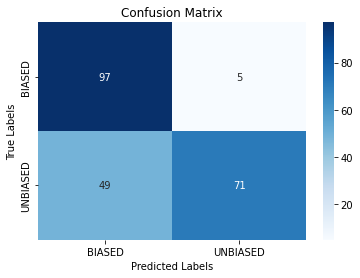

In [20]:
# Evaluation Function

def evaluate(model, test_loader, version='title'):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0): 
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            output = model(input_ids, attention_mask)
            output = torch.sigmoid(output).cpu().detach().numpy().tolist()
            output = np.round(output)
            y_pred.extend(output.tolist())
            y_true.extend(data['targets'].tolist())
    
    print('Classification Report:')
    print('remember: 1 = BIASED, 0 = UNBIASED')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    ax.yaxis.set_ticklabels(['BIASED', 'UNBIASED'])
    
    
best_model = BLOOMClass().to(device)
optimizer = torch.optim.Adam(params =  best_model.parameters(), lr=1e-5)

load_checkpoint(destination_folder + '/bloom_model_' + dataset + '.pt', best_model, optimizer)
evaluate(best_model, test_loader)